---
# <div align="center"><font color='green'> COSC 2673/2793 | Machine Learning  </font></div>
## <div align="center"> <font color='green'> Week 6 Lab Exercises: **Decision Trees**</font></div>
---

# Introduction

During the last couple of weeks we learned about the typical ML model development process. In this weeks lab we will explore decision tree based models. 

The lab assumes that you have completed the labs for week 2-5. If you havent yet, please do so before attempting this lab. 

The lab can be executed on either your own machine (with anaconda installation) or on AWS educate classroom setup for the course. 
- Please refer canvas for instructions on installing anaconda python or setting up AWS Sagemaker notebook: [Introduction to Amazon Web Services (AWS) Classrooms](https://rmit.instructure.com/courses/79534/pages/introduction-to-amazon-web-services-aws-classrooms?module_item_id=2952364)


## Objective
- Continue to familiarise with Python and other ML packages.
- Learning classification decision trees from both categorical and continuous numerical data
- Comparing the performance of various trees after pruned.
- Learning regression decision trees and comparing these models to regression models from previous labs.


## Dataset

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed. 

#### Input variables:
- Bank client data:
    1. age (numeric)
    2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 
    3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
    4. education (categorical: "unknown","secondary","primary","tertiary")
    5. default: has credit in default? (binary: "yes","no")
    6. balance: average yearly balance, in euros (numeric) 
    7. housing: has housing loan? (binary: "yes","no")
    8. loan: has personal loan? (binary: "yes","no")
- Related with the last contact of the current campaign:
    9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
    10. day: last contact day of the month (numeric)
    11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
    12. duration: last contact duration, in seconds (numeric)
- Other attributes:
    13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
    15. previous: number of contacts performed before this campaign and for this client (numeric)
    16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
    
#### Output variable (desired target):   
    17. y - has the client subscribed a term deposit? (binary: "yes","no")
    
This dataset is public available for research. The details are described in Moro et al., 2011.

Moro et al., 2011: S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. 

Lets read the data first.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('./bank-full.csv', delimiter=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


The dataset contains categorical and numerical attributes. Lets convert the categorical columns to categorical data type in pandas. 

In [2]:
for col in data.columns:
    if data[col].dtype == object:
        data[col] = data[col].astype('category')

sklearn’s classification decision tree learner doesn’t work with categorical attributes.  It only works with continuous numeric attributes.  The target class, however, must be categorical.  So the categorical attributed must be converted into a suitable continuous format. Helpfully, Pandas can do this. 

First, split the data into the target class and attributes:

In [3]:
dataY = data['y']
dataX = data.drop(columns='y')

Then use Pandas to generate "numerical" versions of the attributes:

In [4]:
dataXExpand = pd.get_dummies(dataX)
dataXExpand.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


As you can see, the categories are expanded into boolean (yes/no, that is, 1/0) values that can be treated as continuous numerical values. It’s not ideal, but it will allow a correct decision tree to be learned.


<span style="font-size:1.5em;">�</span> Why is it necessary to convert the attributes into boolean representations, rather than just convert them into integer values? What problem would be caused by converting the attributes into integers?

The target class also needs to be pre-processed.  The target will be treated by sklearn as a category, but sklearn requires that these categories are represented as integers (not strings). To convert the strings into numbers, the preprocessing. LabelEncoder class from sklearn can be used, as shown below. The two print statements show how to convert in both directions (strings to integers, and vice-versa).

In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(dataY)
class_labels = le.inverse_transform([0,1])
dataY = le.transform(dataY)
print(dataY)
print(class_labels)

[0 0 0 ... 1 0 0]
['no' 'yes']


# EDA
> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Since we have covered how to do EDA in the previous labs, this section is left as an exercise for you. Complete the EDA and use the information to justify the decisions made in the subsequent code blocks.</font>**  

In [6]:
# TODO


# Setting up the performance (evaluation) metric
There are many performance metrics that apply to this problem such as `accuracy_score`, `f1_score`, etc. More information on performance metrics available in sklearn can be found at: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

The insights gained in the EDA becomes vital in determining the performance metric. Try to identify the characteristics that are important in making this decision from the EDA results. Use your judgment to pick the best performance measure - discuss with the lab demonstrator to see if the performance measure you came up with is appropriate. 


In this task, I want to give equal importance to all classes. Therefore I will select `macro-averaged` `f1_score` as my performance measure and I wish to achieve a target value of 75% f1_score. 

F1-score is NOT the only performance measure that can be used for this problem.


# Setup the experiment - data splits

Next **what data should we use to evaluate the performance?**


We can generate "simulated" unseen data in several methods
1. Hold-Out validation
2. Cross-Validation

Lets use hold out validation for this experiment.

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Use the knowledge from last couple of weeks to split the data appropriately.</font>**  

In [7]:
from sklearn.model_selection import train_test_split

with pd.option_context('mode.chained_assignment', None):
    train_data_X_, test_data_X, train_data_y_ , test_data_y = train_test_split(dataXExpand, dataY, test_size=0.2, 
                                              shuffle=True,random_state=0)
    
with pd.option_context('mode.chained_assignment', None):
    train_data_X, val_data_X, train_data_y, val_data_y = train_test_split(train_data_X_, train_data_y_, test_size=0.25, 
                                            shuffle=True,random_state=0)
    
print(train_data_X.shape, val_data_X.shape, test_data_X.shape)

(27126, 51) (9042, 51) (9043, 51)


In [8]:
train_X = train_data_X.to_numpy()
train_y = train_data_y

test_X = test_data_X.to_numpy()
test_y = test_data_y

val_X = val_data_X.to_numpy()
val_y = val_data_y

Lets setup few functions to visualise the results.

(Ignore section if on AWS) It is likely that you won’t have the graphviz package available, in which case you will need to install graphviz. This can be done through the anacoda-navigator interface (environment tab):
1. Change the dropbox to “All”
2. Search for the packagecpython-graphviz
3. Select the python-graphviz package and install (press “apply”)

If you cant install graphviz don’t worry - you can still complete the lab. Graphviz is nice to be able to see the trees that are being calculated. However, once the trees become complex, visualising them isn’t practical.

In [17]:
import graphviz 

def get_tree_2_plot(clf):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=dataXExpand.columns,  
                      class_names=class_labels,  
                      filled=True, rounded=True,  
                      special_characters=True)  
    graph = graphviz.Source(dot_data) 
    return graph

In [ ]:
from sklearn.metrics import f1_score

def get_acc_scores(clf, train_X, train_y, val_X, val_y):
    train_pred = clf.predict(train_X)
    val_pred = clf.predict(val_X)
    
    train_acc = f1_score(train_y, train_pred, average='macro')
    val_acc = f1_score(val_y, val_pred, average='macro')
    
    return train_acc, val_acc

# Simple decision tree training

Lets train a simple decision tree and visualize it.

In [28]:
from sklearn import tree

tree_max_depth = 3   #change this value and observe

clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=tree_max_depth, class_weight='balanced')
clf = clf.fit(train_X, train_y)

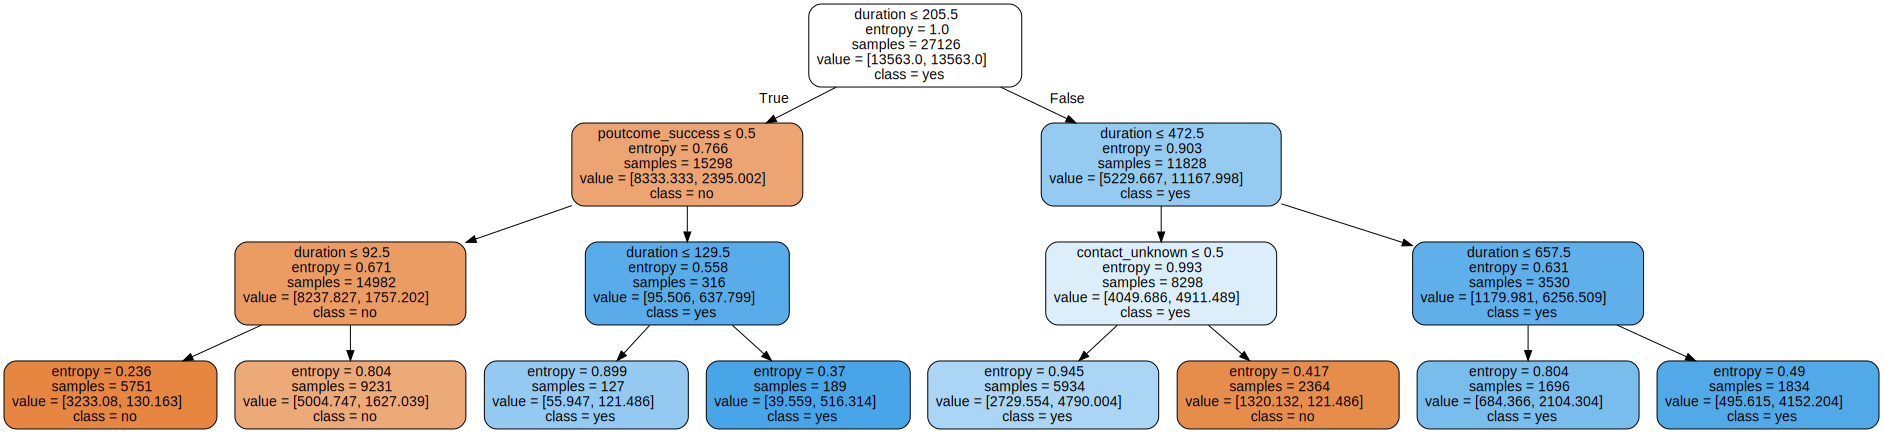

In [29]:
Dtree = get_tree_2_plot(clf)
Dtree

In [30]:
train_acc, val_acc = get_acc_scores(clf,train_X, train_y, val_X, val_y)
print("Train f1 score: {:.3f}".format(train_acc))
print("Validation f1 score: {:.3f}".format(val_acc))

Train f1 score: 0.618
Validation f1 score: 0.629


<span style="font-size:1.5em;">�</span> Did we achieve the desired target value? If not what do you thing the above results indicate: over-fitting, under-fitting

<span style="font-size:1.5em;">�</span> Based on the answer to the above question, what do you think is the best course of action?

## Hyper parameter tuning

<span style="font-size:1.5em;">�</span> What are the hyper parameters of the `DecisionTreeClassifier`?

You may decide to tune the important hyper-paramters of the decision tree classifier (identified in the above question) to get the best performance. As an example I have selected two hyper parameters:  `max_depth` and `min_samples_split`.

In this exercise I will be using GridSearch to tune my parameters. Sklearn has a function that do cross validation to tune the hyper parameters called `GridSearchCV`. Lets use this function. 

*This step may take several steps depending on the performance of your computer*

In [32]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':np.arange(2,400, 50), 'min_samples_split':np.arange(2,50,5)}

dt_clf = tree.DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
Gridclf = GridSearchCV(dt_clf, parameters, scoring='f1_macro')
Gridclf.fit(train_X, train_y)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='entropy'),
             param_grid={'max_depth': array([  2,  52, 102, 152, 202, 252, 302, 352]),
                         'min_samples_split': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47])},
             scoring='f1_macro')

In [33]:
pd.DataFrame(Gridclf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.049281,0.008001,0.003754,0.000063,2,2,"{'max_depth': 2, 'min_samples_split': 2}",0.555917,0.523732,0.549189,0.608921,0.553087,0.558169,0.027832,71
1,0.044232,0.000552,0.003749,0.000080,2,7,"{'max_depth': 2, 'min_samples_split': 7}",0.555917,0.523732,0.549189,0.608921,0.553087,0.558169,0.027832,71
2,0.044191,0.000142,0.003665,0.000115,2,12,"{'max_depth': 2, 'min_samples_split': 12}",0.555917,0.523732,0.549189,0.608921,0.553087,0.558169,0.027832,71
3,0.043949,0.000390,0.003680,0.000123,2,17,"{'max_depth': 2, 'min_samples_split': 17}",0.555917,0.523732,0.549189,0.608921,0.553087,0.558169,0.027832,71
4,0.044509,0.000922,0.003706,0.000127,2,22,"{'max_depth': 2, 'min_samples_split': 22}",0.555917,0.523732,0.549189,0.608921,0.553087,0.558169,0.027832,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.214441,0.003416,0.004260,0.000143,352,27,"{'max_depth': 352, 'min_samples_split': 27}",0.714483,0.698027,0.703760,0.705907,0.714473,0.707330,0.006380,60
76,0.212673,0.005101,0.004303,0.000116,352,32,"{'max_depth': 352, 'min_samples_split': 32}",0.713605,0.698488,0.706792,0.710185,0.717460,0.709306,0.006467,27
77,0.209610,0.003428,0.004310,0.000068,352,37,"{'max_depth': 352, 'min_samples_split': 37}",0.710591,0.694774,0.709113,0.710323,0.715955,0.708151,0.007092,45
78,0.206552,0.004387,0.004286,0.000096,352,42,"{'max_depth': 352, 'min_samples_split': 42}",0.714603,0.700340,0.709401,0.713924,0.712000,0.710053,0.005182,17


In [34]:
print(Gridclf.best_score_)
print(Gridclf.best_params_)

clf = Gridclf.best_estimator_

0.711144876401699
{'max_depth': 52, 'min_samples_split': 47}


In [35]:
train_acc, val_acc = get_acc_scores(clf,train_X, train_y, val_X, val_y)
print("Train f1 score: {:.3f}".format(train_acc))
print("Validation f1 score: {:.3f}".format(val_acc))

Train f1 score: 0.783
Validation f1 score: 0.722


<span style="font-size:1.5em;">�</span> Did we achieve the desired target value? If not what do you thing the above results indicate: over-fitting, under-fitting

<span style="font-size:1.5em;">�</span> Based on the answer to the above question, what do you think is the best course of action?

## Post pruning decision trees with cost complexity pruning


The DecisionTreeClassifier provides parameters such as min_samples_leaf and max_depth to prevent a tree from overfitting. Those parameters prevent the tree from growing to large size and are examples of pre pruning. 

Minimal cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting. This algorithm finds the node with the ''weakest link'' characterised by an effective alpha. Then the nodes with the smallest effective alpha are pruned first. as the algorithm works after the tree is grown, this is a post pruning technique. 

In [36]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')
path = clf.cost_complexity_pruning_path(train_X, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

*The following step may take several steps depending on the performance of your computer*

In [37]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, class_weight='balanced')
    clf.fit(train_X, train_y)
    clfs.append(clf)

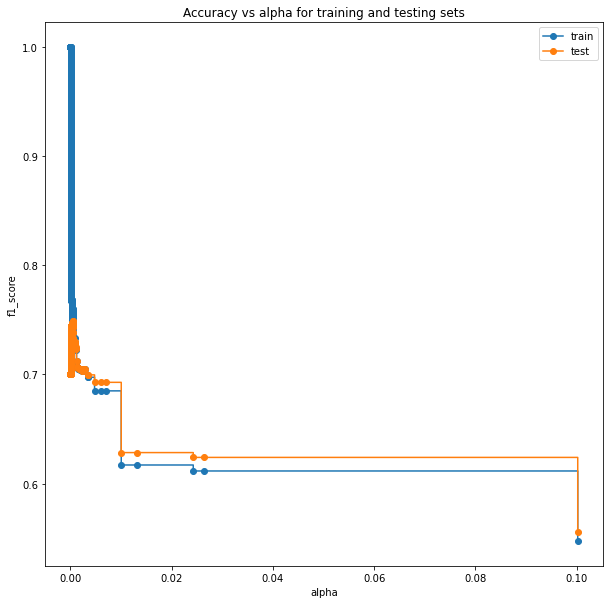

In [38]:
train_scores = [f1_score(train_y, clf.predict(train_X), average='macro') for clf in clfs]
val_scores = [f1_score(val_y, clf.predict(val_X), average='macro') for clf in clfs]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("alpha")
ax.set_ylabel("f1_score")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

<span style="font-size:1.5em;">�</span> What `ccp_alphas` value would you choose as the best for the task?

# Random forest

Lets make many trees using our dataset. If we run the DT algorithm multiple times on same data, it will result in the same tree. To make different trees we can inject some randomness. Select data data points and features to be used in DT algorithm randomly - this process is called creating boor strapped datasets.

This is automatically done in sklearn for us in the `RandomForestClassifier`. Lets use that on our dataset. 

In [39]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=8, n_estimators=500, class_weight='balanced_subsample', random_state=0)
clf.fit(train_X, train_y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       n_estimators=500, random_state=0)

In [40]:
train_acc, val_acc = get_acc_scores(clf, train_X, train_y, val_X, val_y)
print("Train Accuracy score: {:.3f}".format(train_acc))
print("Validation Accuracy score: {:.3f}".format(val_acc))

Train Accuracy score: 0.746
Validation Accuracy score: 0.732


> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Now tune the hyper parameters of the random forest.</font>**  

<span style="font-size:1.5em;">�</span> Is the final model that you get after hyper parameter tuning better than the previous decision tree model? Why?

Lets visualise the feature importance of the RF classifier.

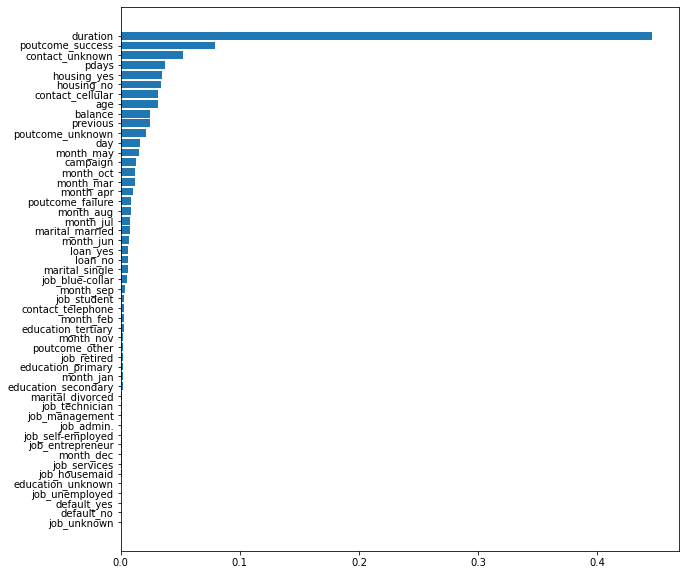

In [41]:
tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

plt.figure(figsize=(10,10))
plt.barh(dataXExpand.columns[sorted_idx], tree_feature_importances[sorted_idx])
plt.show()

<span style="font-size:1.5em;">�</span> Based on the above figure, do you see any reason to be concerned about the model?

<span style="font-size:1.5em;">�</span> If the model uses `duration` to predict the target, what can be an issue?

# Exercise: Regression Decision Tree

A regression decision tree can also be trained.  These are decision trees where the leaf node is a regression function. You will investigate learning regression trees using the boston housing data set from previous labs.

The below code snippet will help get you started. Note that it does not make sense to use entropy for generating splits, so the default method from sklearn will be used. Also note that the DecisionTreeRegressor class uses similar pre-pruning parameters.

In [42]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import sklearn 

# from sklearn import tree
# from sklearn import preprocessing
# from sklearn import metrics
# from sklearn import model_selection

# Load data

# bostonDataTarget = bostonData['MEDV']
# bostonDataAttrs = bostonData.drop(columns='MEDV')
# trainY, testY, trainX, testX = model_selection.train_test_split(np.array(bostonDataTarget),np.array(bostonDataAttrs), test_size=0.2)
# clfBoston = sklearn.tree.DecisionTreeRegressor(max_depth=5, min_samples_split=5)
# clfBoston = clfBoston.fit(trainX, trainY)
# predictions = clfBoston.predict(testX)
# metrics.mean_squared_error(testY, predictions)

<span style="font-size:1.5em;">�</span> How does the error on the regression decision tree compare to the best results you have found in previous labs?
    
<span style="font-size:1.5em;">�</span> Find a good set of pre-pruning parameters that minimises the mean square error